#### Consider Outliers
Many time series start off with some form of irregularity which could throw us off - TODO
#### Consider Normalising
We are *probably* not interested in absolute heart rate, or voltage levels.
So these can be normalised to make them easier to work on
#### Classes are humanly understandable
There are 4 classes:
 - (0) healthy
 - (1) arythmia1 (qualitatively?)
 - (2) arythmia2 (qualitatively?)
 - (3) noisy

#### Start with very simple features
- Look at K timestamp intervals 
- Try averaging between heartbeat windows 

#### Class imbalance
 Training set counts for the 4 classes are respectively [3030 443 1474 170]
 
#### Manual Feature extraction
- RR interval - DONE
- R amplitude - DONE
- Q amplitude - DONE
- QRS duration - DONE
- Heart rate variability - DONE
- Wavelet energy - TODO

#### consider using inter-qualtile ranges instead of variance 

##### Print Progress

`[(not i%100 and print(i)) or process(row) for i, row in table]`

In [1]:
backed_up = False

In [2]:
import csv
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 7)
#plt.style.use('dark_background')

In [3]:
freq = 300.

In [4]:
# returns a dict mapping sample id [int] to the raw time series [np.array]
def importTimeSeries(filename):
    datafile = open(filename, 'r')
    datareader = csv.reader(datafile)
    out = dict()
    first = True
    for row in datareader:
        if first:
            first = False
            continue
        out[int(row[0])] = np.asarray(row[1:], dtype=float)
    return out

X_train = importTimeSeries('X_train.csv')
X_test  = importTimeSeries('X_test.csv')
train = pd.read_csv('y_train.csv').set_index('id',drop=False)
test  = pd.read_csv('sample.csv').set_index('id',drop=False)
train['X'] = [X_train[k] for k in train.index.values]
test['X']  = [X_test[k]  for k in test.index.values]
n_train = len(train)
n_test  = len(test)
print(n_train)
print(n_test)

5117
3411


In [5]:
predicting = False # set to True when you come back here after fitting the Model
# this is ugly but yeah it's 2 am
if predicting:
    if not backed_up: 
        train_bk = train.copy()
        backed_up = True
        train = test
        n_train = n_test
else:
    if backed_up:
        train = train_bk
        n_train = len(train)
        backed_up = False

In [6]:
from biosppy.signals import ecg
train['ecg'] = [ecg.ecg(signal=x, sampling_rate=freq, show=False) for x in train.X]

In [7]:
train['dur'] = [len(x) for x in train.X]

In [8]:
# Unpack the ecg tuple into the dataframe
for field in train.ecg[0].keys():
    train[field] = [e[field] for e in train.ecg]
train['int_rpeaks'] = train.rpeaks
train = train.drop(['rpeaks'],axis=1)
print(train.columns.values)

['id' 'y' 'X' 'ecg' 'dur' 'ts' 'filtered' 'templates_ts' 'templates'
 'heart_rate_ts' 'heart_rate' 'int_rpeaks']


## Tedious hand crafting of features
You might want to remove some of the intervals before processing ...

In [9]:
# don't remember why we don't trust the default rpeaks...
train['rpeaks'] = [ecg.correct_rpeaks(signal=row.X, 
                                   rpeaks=row.int_rpeaks, 
                                   sampling_rate=freq, 
                                   tol=0.1)[0] for _,row in train.iterrows()] 

In [10]:
train['peaks'] = [row.X[row.rpeaks] for _,row in train.iterrows()] 

In [11]:
from biosppy.signals.tools import *

In [12]:
train['stats'] = [signal_stats(filt) for filt in train.filtered]
# Unpack the stats tuple into the dataframe
for field in train.stats[0].keys():
    train[field] = [stats[field] for stats in train.stats]

In [13]:
# Candidates for summarizing into a single template
train['avg_tempt'] = [np.mean(tempts, axis=0)   for tempts in train.templates]
train['med_tempt'] = [np.median(tempts, axis=0) for tempts in train.templates]
train['var_tempt'] = [np.var(tempts, axis=0)    for tempts in train.templates]
train['std_tempt'] = [np.std(tempts, axis=0)    for tempts in train.templates]
train['max_tempt'] = [np.max(tempts, axis=0)    for tempts in train.templates]
train['min_tempt'] = [np.min(tempts, axis=0)    for tempts in train.templates]
train['n_tempts']  = [np.shape(tempts)[0]    for tempts in train.templates]
# template timestamps are the same for all templates on all signals (-2 to +4 seconds)
templates_ts = train.loc[0].templates_ts

In [14]:
# stats from summarized templates
train['tempt_stats'] = [signal_stats(med) for med in train.med_tempt]
# Unpack the stats tuple into the dataframe
for field in train.tempt_stats[0].keys():
    train['tempt_'+field] = [stats[field] for stats in train.tempt_stats]
    
train['tempt_min'] = [np.min(med) for med in train.med_tempt]

In [15]:
missing_hr = [len(hr)==0 for hr in train.heart_rate]
print(train[missing_hr].id.values)
for id in train[missing_hr].index:
    train.at[id,'heart_rate'] = [0]
    train.at[id,'heart_rate_ts'] = [0]

[ 628 3500 3720 4701]


In [16]:
unique_hr = [len(hr)==1 for hr in train.heart_rate]
print(train[unique_hr].id.values)
for id in train[unique_hr].index:
    hr = train.loc[id].heart_rate[0]
    train.at[id,'heart_rate'] = [hr,hr+0.0001]
    train.at[id,'heart_rate_ts'] = [0,0.0001]

[ 628 1986 3500 3720 4701]


In [17]:
couple_hr = [len(hr)==2 for hr in train.heart_rate]
print(train[couple_hr].id.values)
for id in train[couple_hr].index:
    hr = train.loc[id].heart_rate[1]
    train.at[id,'heart_rate']    = [hr,hr,hr+0.0001]
    train.at[id,'heart_rate_ts'] = [0, 0.0001 , 0.0002]

[ 628 1986 3500 3720 3822 3953 4701]


In [18]:
train['hr_stats'] = [signal_stats(row.heart_rate) for i, row in train.iterrows()]
train['hr_min'] = [np.min(hr) for hr in train.heart_rate]

In [19]:
# Unpack the stats tuple into the dataframe
for field in train.hr_stats[0].keys():
    train['hr_'+field] = [stats[field] for stats in train.hr_stats]

In [20]:
train['heart_rate_diff'] = [np.diff(heart_rate) for heart_rate in train.heart_rate]
train['dhr_stats'] = [signal_stats(row.heart_rate_diff) for i, row in train.iterrows()]
train['dhr_min'] = [np.min(dhr) for dhr in train.heart_rate_diff]
# Unpack the stats tuple into the dataframe
for field in train.dhr_stats[0].keys():
    train['dhr_'+field] = [stats[field] for stats in train.dhr_stats]

In [21]:
# find that bloody sample with flat heart rate
bitches = train[train.hr_var==0].id.values
if len(bitches)==0: 
    print('bitches be gone')
else:
    print(bitches)
    bitch = bitches[0]
    temp = train.loc[bitch].heart_rate
    temp[0] += 0.0001 # wiggle the first sample
    train.at[bitch,'heart_rate'] = temp # and put it back
    train.at[bitch,'hr_stats'] = signal_stats(temp)

[2710]


In [22]:
train[np.isnan(train.hr_std_dev)]
# must be NaN free before you continue

,id,y,X,ecg,dur,ts,filtered,templates_ts,templates,heart_rate_ts,...,dhr_stats,dhr_min,dhr_mean,dhr_median,dhr_max,dhr_var,dhr_std_dev,dhr_abs_dev,dhr_kurtosis,dhr_skewness
id,,,,,,,,,,,,,,,,,,,,,


In [23]:
train['intervs']     = [np.diff(rpeaks)    for rpeaks  in train.rpeaks]
train['mean_interv'] = [np.mean(intervs)   for intervs in train.intervs]
train['var_interv']  = [np.var(intervs)    for intervs in train.intervs]
train['std_interv']  = [np.std(intervs)    for intervs in train.intervs]
train['med_interv']  = [np.median(intervs) for intervs in train.intervs]
train['min_interv']  = [np.min(intervs) for intervs in train.intervs]
train['max_interv']  = [np.max(intervs) for intervs in train.intervs]

In [24]:
from QRS_util import*
def findQS(signal):
    R_peaks, S_point, Q_point = EKG_QRS_detect(signal, freq, True, False)
from scipy.stats import iqr
def get_g_feats(templates):
    keys = [ 'numex',
         'varex',
         'S',
         'Q',
         #'R',
         'Sv',
         'Rv',
         'Qv',
         'numz',
         'QZ',
         'SZ',
         'QS',
         'QZSZ']
    n_tempts = np.shape(templates)[0]
    g_features = {key: np.zeros(n_tempts) for key in keys}
    
    R = np.array([60])# R is always at sample 60 within the template

    for i in range(n_tempts):
        signal = templates[i]
        extrema, values = find_extrema(signal)
        g_features['numex'][i] = len(extrema)
        g_features['varex'][i] = np.var(values)
        
        S = find_S_point(signal, R)[0]
        Q = find_Q_point(signal, R)[0]

        g_features['S'][i] = S
        g_features['Q'][i] = Q
        #g_features['R'].append(R[0]) 

        zeros = zero_cross(signal)['zeros']
        g_features['numz'][i] = len(zeros)
        QZ = np.max(np.append(zeros[zeros<Q],0))
        SZ = np.min(np.append(zeros[zeros>S],179)) # 179 is last index in each template
        g_features['QZ']  [i] = QZ
        g_features['SZ']  [i] = SZ
        
        g_features['QS']  [i] = S-Q
        g_features['QZSZ'][i] = SZ-QZ  
        
        g_features['Sv']  [i] = signal[S]
        g_features['Rv']  [i] = signal[R]
        g_features['Qv']  [i] = signal[Q]  
        
    return g_features

def get_g_stats(templates):
    g_features = get_g_feats(templates) 
    
    g_stats = dict()
    for key, values in g_features.items():
        npa_val = np.array(values)
        g_stats[key+'_var'] = np.var(npa_val)
        g_stats[key+'_med'] = np.median(npa_val)
        g_stats[key+'_iqr'] = iqr(npa_val)
        
    return g_stats

In [25]:
train['g_feats'] = [get_g_feats([tempt]) for tempt in train.med_tempt]
# Unpack the stats dict into the dataframe
for field in train.g_feats[0].keys():
    train['med_'+field] = [stats[field][0] for stats in train.g_feats]

In [26]:
train['g_stats'] = [get_g_stats(templates) for templates in train.templates]
# Unpack the stats dict into the dataframe
for field in train.g_stats[0].keys():
    train[field] = [stats[field] for stats in train.g_stats]

In [27]:
#noise as difference between before and after filtering
train['noise_avg'] = [np.sum(row.filtered-row.X)/row.dur for _,row in train.iterrows()]

In [28]:
train['noise_rms'] = [rms_error(row.filtered, row.X)[0] for _,row in train.iterrows()]

# wavelets

## END of manual feature extraction, this is what you got:

In [29]:
from pprint import pprint
pprint(train.columns.values.tolist())

['id',
 'y',
 'X',
 'ecg',
 'dur',
 'ts',
 'filtered',
 'templates_ts',
 'templates',
 'heart_rate_ts',
 'heart_rate',
 'int_rpeaks',
 'rpeaks',
 'peaks',
 'stats',
 'mean',
 'median',
 'max',
 'var',
 'std_dev',
 'abs_dev',
 'kurtosis',
 'skewness',
 'avg_tempt',
 'med_tempt',
 'var_tempt',
 'std_tempt',
 'max_tempt',
 'min_tempt',
 'n_tempts',
 'tempt_stats',
 'tempt_mean',
 'tempt_median',
 'tempt_max',
 'tempt_var',
 'tempt_std_dev',
 'tempt_abs_dev',
 'tempt_kurtosis',
 'tempt_skewness',
 'tempt_min',
 'hr_stats',
 'hr_min',
 'hr_mean',
 'hr_median',
 'hr_max',
 'hr_var',
 'hr_std_dev',
 'hr_abs_dev',
 'hr_kurtosis',
 'hr_skewness',
 'heart_rate_diff',
 'dhr_stats',
 'dhr_min',
 'dhr_mean',
 'dhr_median',
 'dhr_max',
 'dhr_var',
 'dhr_std_dev',
 'dhr_abs_dev',
 'dhr_kurtosis',
 'dhr_skewness',
 'intervs',
 'mean_interv',
 'var_interv',
 'std_interv',
 'med_interv',
 'min_interv',
 'max_interv',
 'g_feats',
 'med_numex',
 'med_varex',
 'med_S',
 'med_Q',
 'med_Sv',
 'med_Rv',
 'med

## do some analysis

In [30]:
# USEFUL ANALYIS STUFF
def subsets():
    train0 = train[train.y==0]
    train1 = train[train.y==1]
    train2 = train[train.y==2]
    train3 = train[train.y==3]
    subs = [train0, train1, train2, train3]
    return subs

def randrow(i):
    if i==-1:
        return train.sample(1).iloc[0]
    else:
        return subsets()[i].sample(1).iloc[0]
    
def box(field):
    plt.boxplot([sub[field] for sub in subsets()], whis=[5, 95])
    plt.show()

In [31]:
subs = subsets()
counts = [len(s) for s in subs]
n0,n1,n2,n3 = counts
print(counts)

[3030, 443, 1474, 170]


In [32]:
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat, '\t',min(train[feat]),max(train[feat]))

id 	 0 5116
y 	 0 3
dur 	 2441 17813
mean 	 -9.306806428288823 8.092012196208067
median 	 -39.63572852474119 40.638434660757845
max 	 34.68227036297856 6797.474441073124
var 	 15.41621002674046 516371.8089028809
std_dev 	 3.9263481795098687 718.5901536361885
abs_dev 	 17745.445608669794 5076090.298790283
kurtosis 	 0.6238906028748405 428.6085510463253
skewness 	 -13.398036388058806 15.507189839844585
n_tempts 	 7 157
tempt_mean 	 -24.924015855470365 137.18513903057186
tempt_median 	 -50.984720976012355 76.92289244689734
tempt_max 	 4.379596826074077 3032.1306675590235
tempt_var 	 1.579517110749697 330329.9518749964
tempt_std_dev 	 1.2567884112887486 574.7433791484652
tempt_abs_dev 	 138.18863452492886 59354.54297112735
tempt_kurtosis 	 -0.15111021080017473 20.882596298043236
tempt_skewness 	 -3.949374608292942 4.136927342279926
tempt_min 	 -2998.1515798799246 -2.8343911995319
hr_min 	 0.0001 199.99999999999997
hr_mean 	 0.00013333333333333334 199.99999999999997
hr_median 	 0.0001 199.9

id


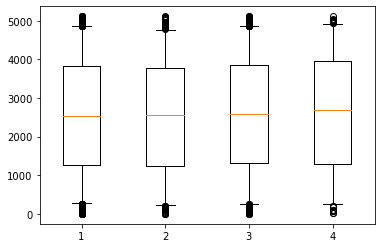

y


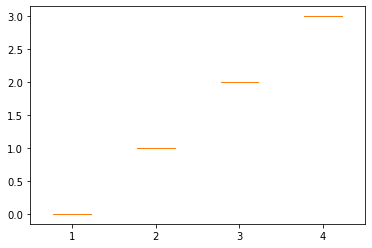

dur


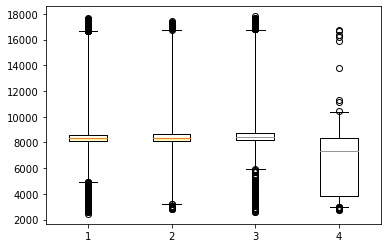

mean


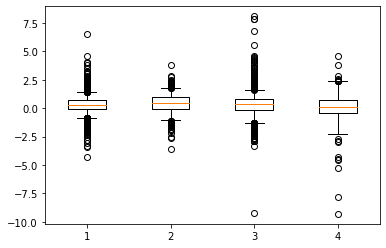

median


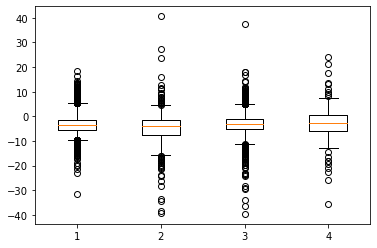

max


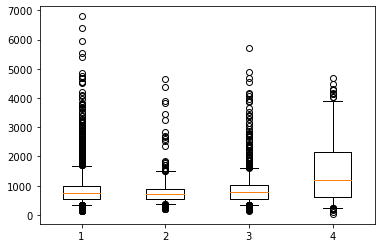

var


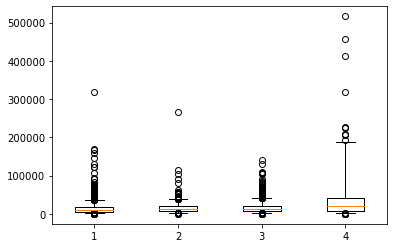

std_dev


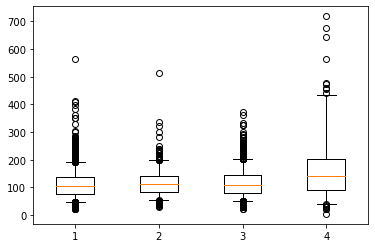

abs_dev


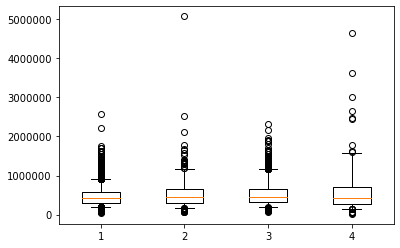

kurtosis


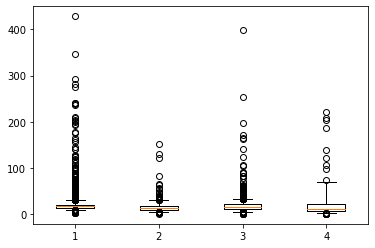

skewness


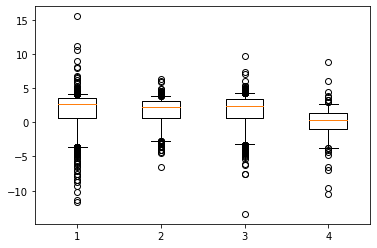

n_tempts


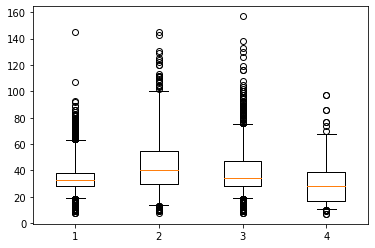

tempt_mean


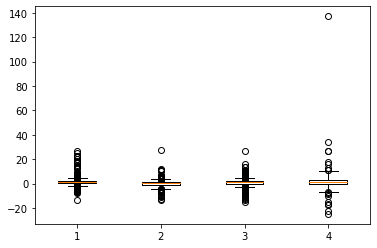

tempt_median


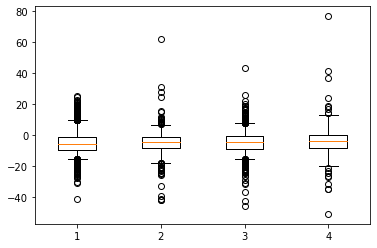

tempt_max


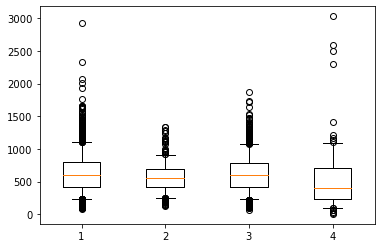

tempt_var


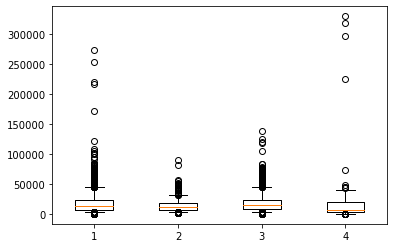

tempt_std_dev


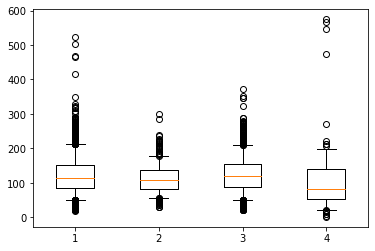

tempt_abs_dev


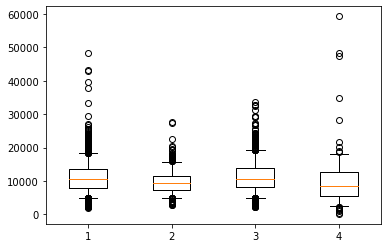

tempt_kurtosis


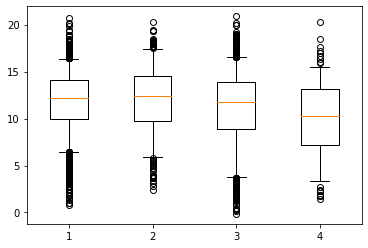

tempt_skewness


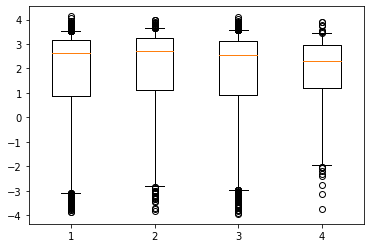

tempt_min


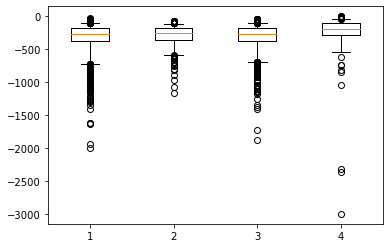

hr_min


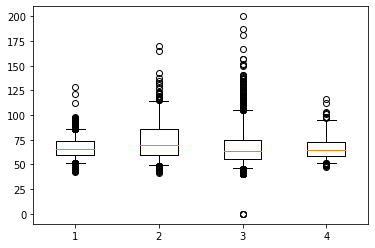

hr_mean


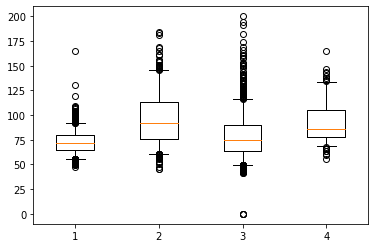

hr_median


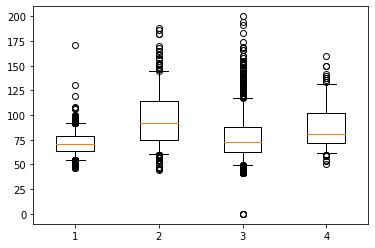

hr_max


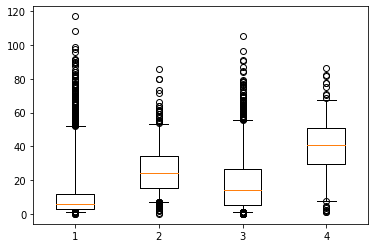

hr_var


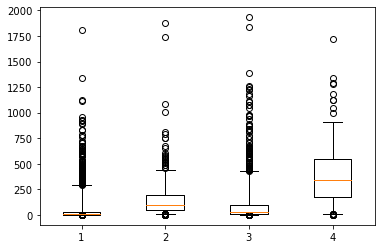

hr_std_dev


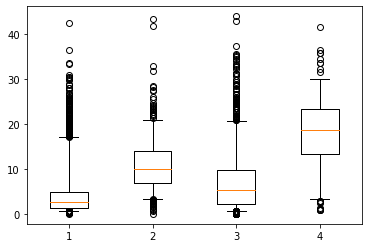

hr_abs_dev


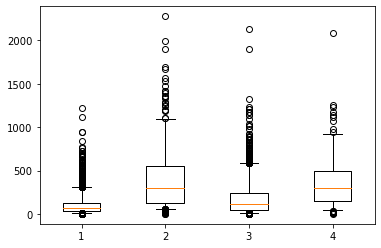

hr_kurtosis


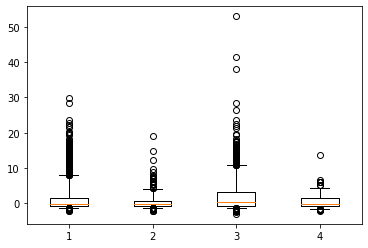

hr_skewness


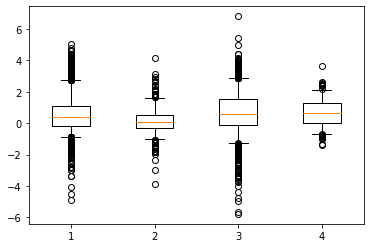

dhr_min


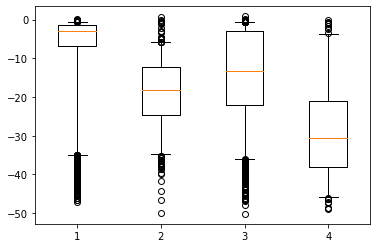

dhr_mean


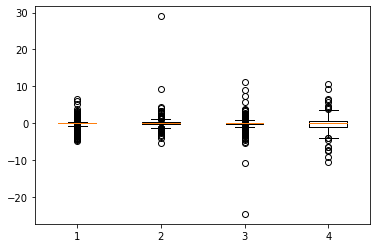

dhr_median


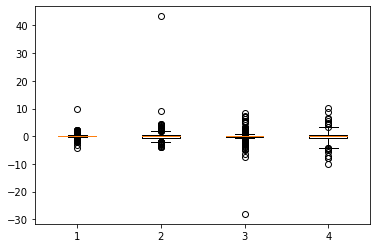

dhr_max


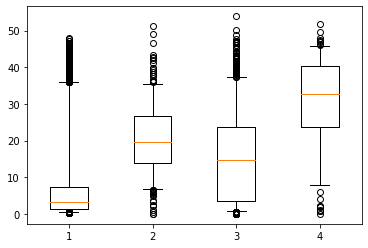

dhr_var


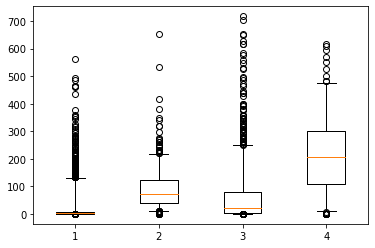

dhr_std_dev


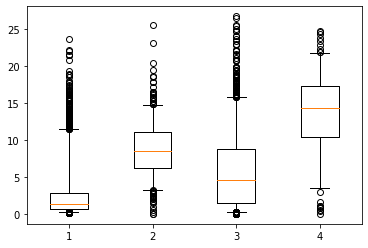

dhr_abs_dev


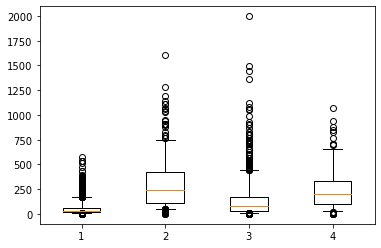

dhr_kurtosis


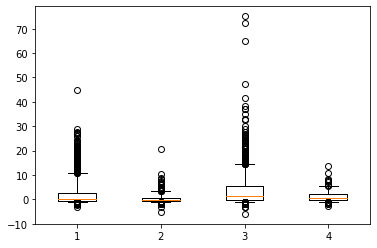

dhr_skewness


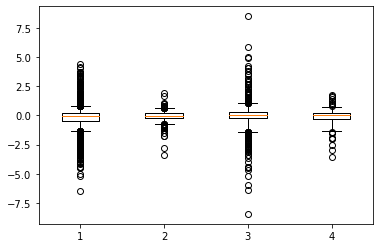

mean_interv


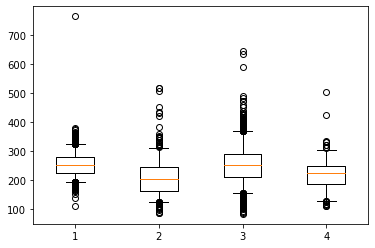

var_interv


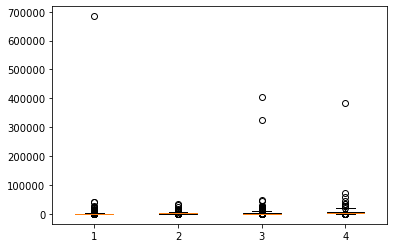

std_interv


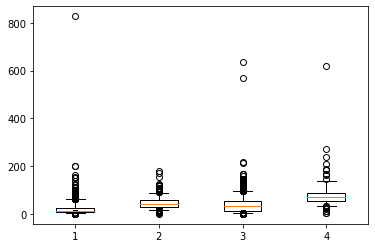

med_interv


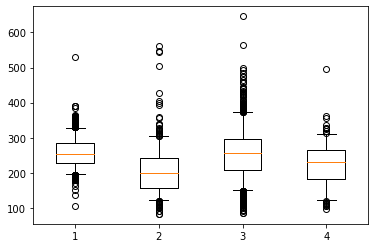

min_interv


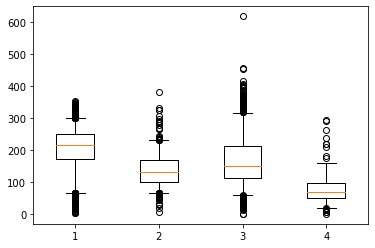

max_interv


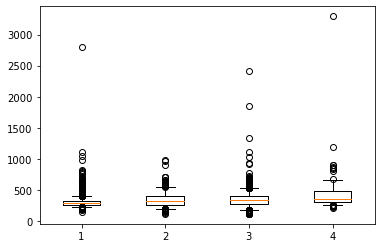

med_numex


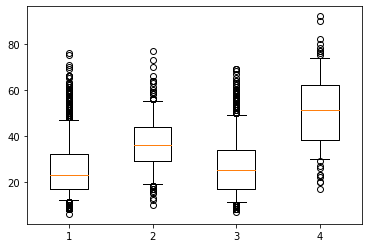

med_varex


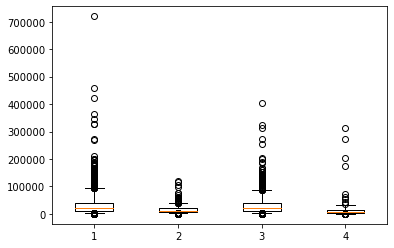

med_S


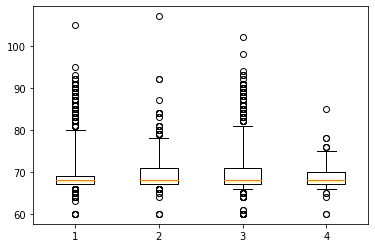

med_Q


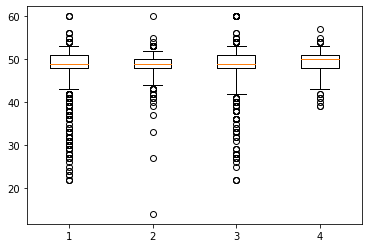

med_Sv


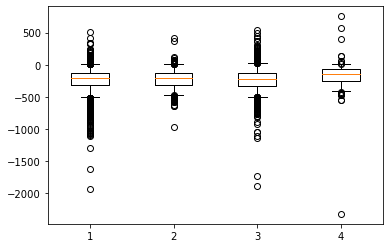

med_Rv


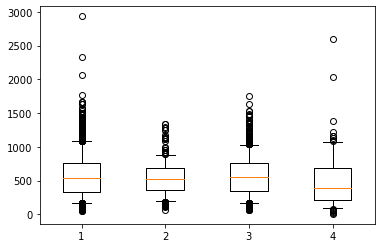

med_Qv


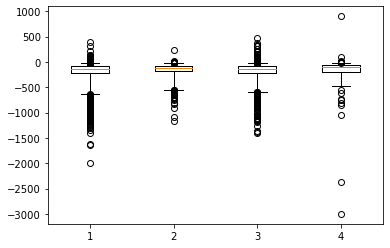

med_numz


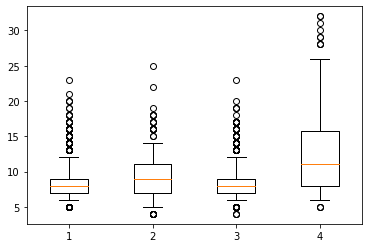

med_QZ


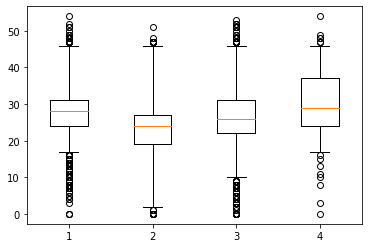

med_SZ


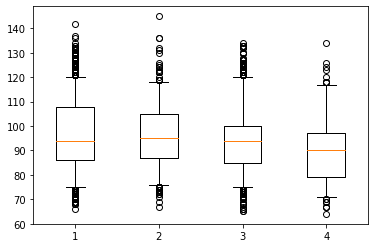

med_QS


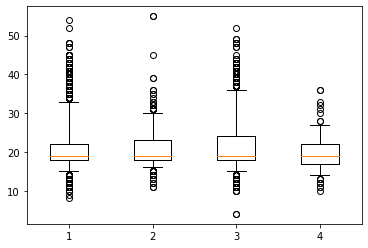

med_QZSZ


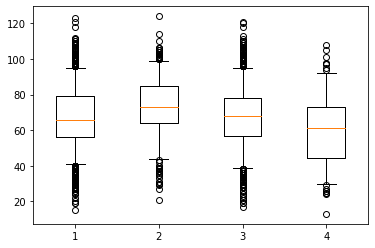

numex_var


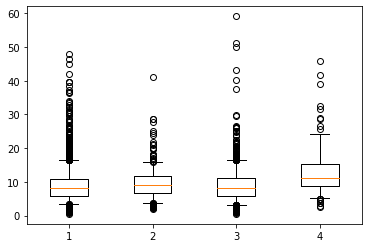

numex_med


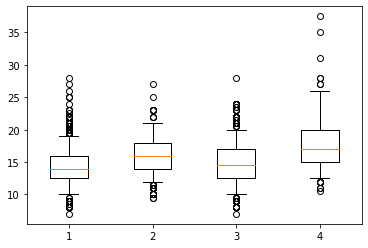

numex_iqr


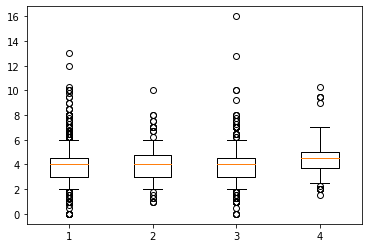

varex_var


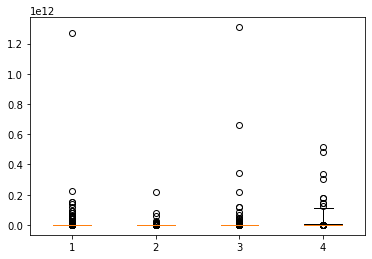

varex_med


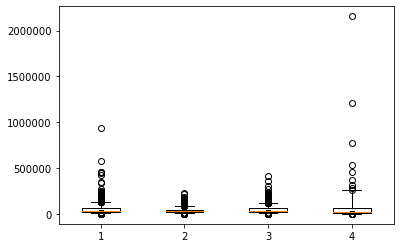

varex_iqr


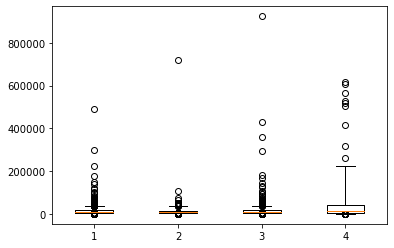

S_var


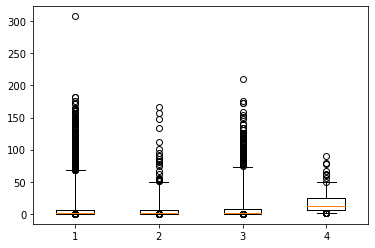

S_med


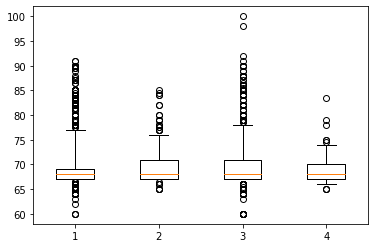

S_iqr


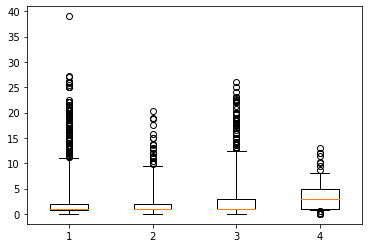

Q_var


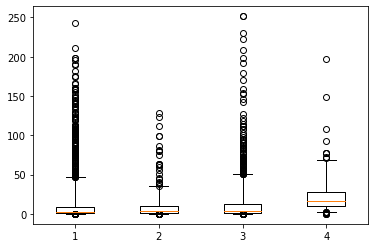

Q_med


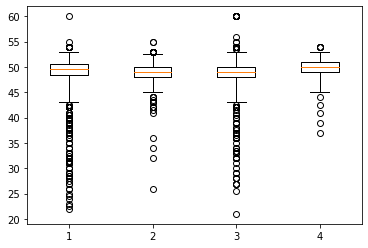

Q_iqr


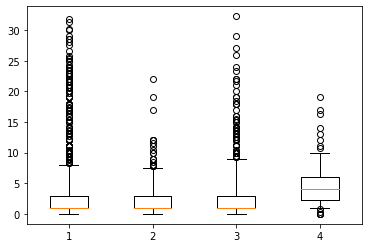

Sv_var


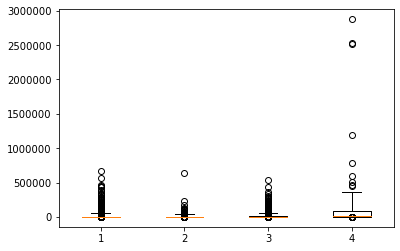

Sv_med


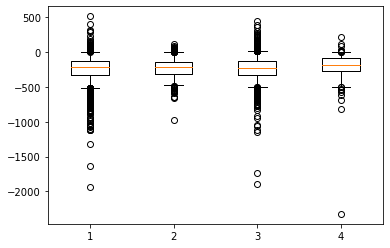

Sv_iqr


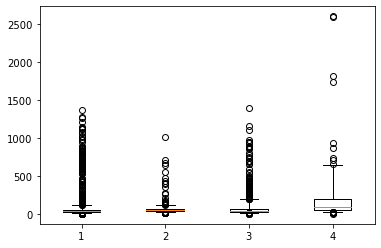

Rv_var


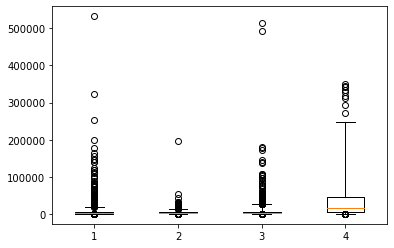

Rv_med


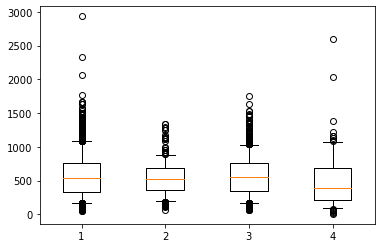

Rv_iqr


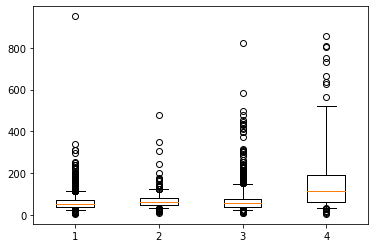

Qv_var


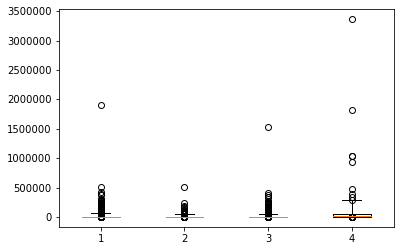

Qv_med


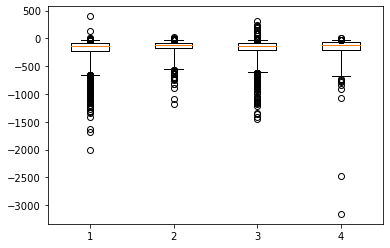

Qv_iqr


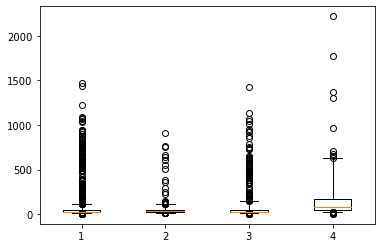

numz_var


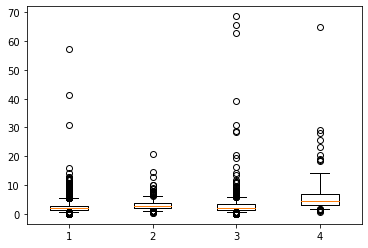

numz_med


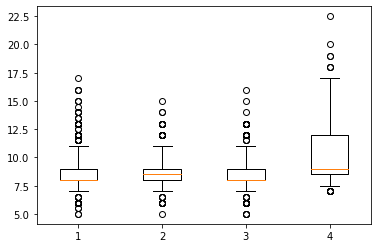

numz_iqr


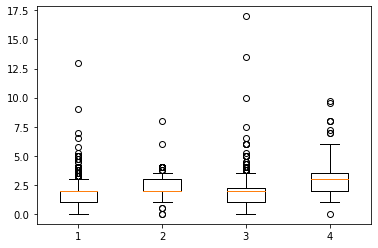

QZ_var


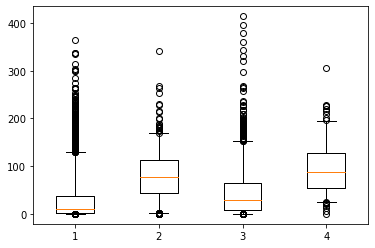

QZ_med


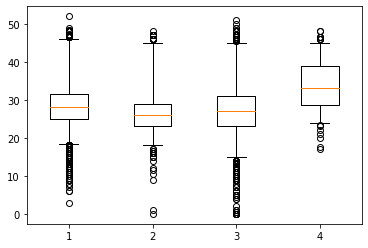

QZ_iqr


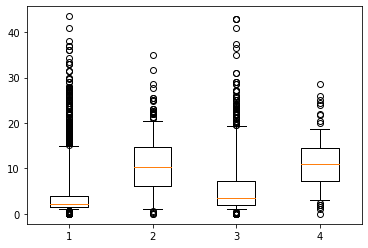

SZ_var


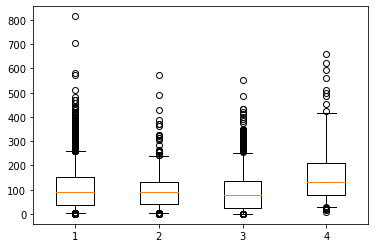

SZ_med


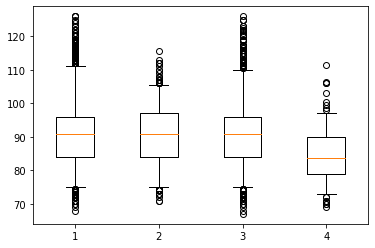

SZ_iqr


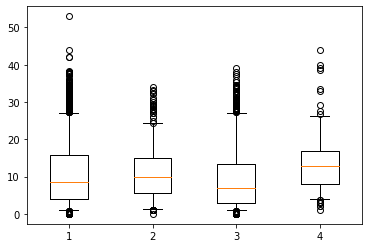

QS_var


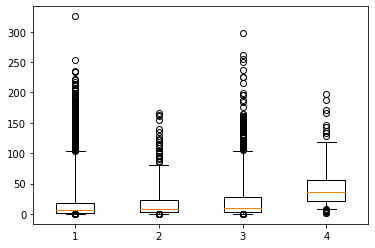

QS_med


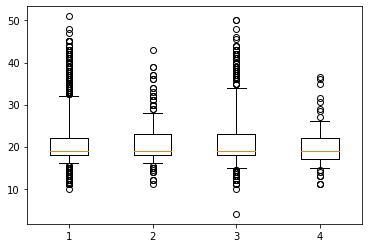

QS_iqr


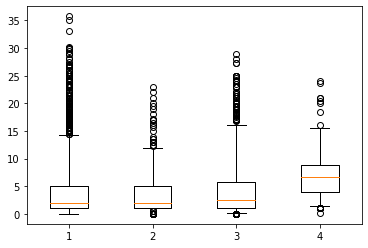

QZSZ_var


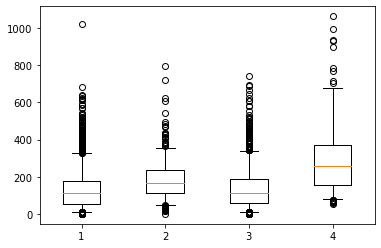

QZSZ_med


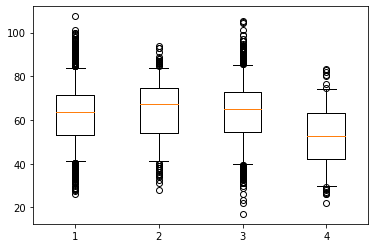

QZSZ_iqr


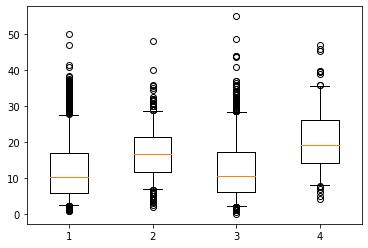

noise_avg


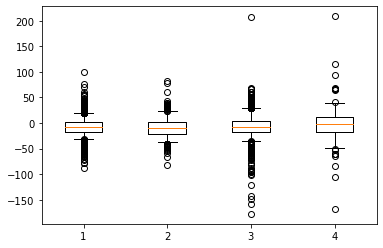

noise_rms


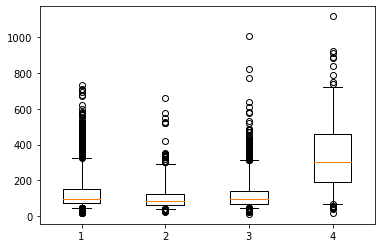

In [33]:
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat)
        box(feat)


# Pre Processing

In [34]:
myfeats = []
for feat in train.columns:
    if feat == 'id' or feat == 'y': continue
    if np.isscalar(train[feat][0]): myfeats.append(feat)

In [195]:
X_raw = train[myfeats].values
y_raw = train['y']
print(np.shape(X_raw))

(5117, 93)


In [234]:
from sklearn.preprocessing import scale
X_raw = scale(X_raw)

/home/seb/miniconda3/envs/aml/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


## PCA ?
could be done on train+test since it's unsupervised

In [252]:
from sklearn.decomposition import PCA
    
if not predicting:
    pca = PCA(n_components=40)
    pca.fit(X_raw)
    print('least important 5:',pca.explained_variance_ratio_[-5:])
    print('explained variance:',sum(pca.explained_variance_ratio_))

X_pca = pca.transform(X_raw)

least important 5: [0.00343593 0.00329308 0.00316016 0.00311447 0.00297158]
explained variance: 0.9517513182594368


In [261]:
i=0
for comp in pca.components_:
    i+=1
    indeces = comp.argsort()[-5:][::-1]
    print('c%d='%i,[myfeats[i] for i in indeces])

c1= ['hr_std_dev', 'dhr_std_dev', 'dhr_max', 'QS_iqr', 'QS_var']
c2= ['std_dev', 'var', 'varex_med', 'tempt_var', 'abs_dev']
c3= ['S_var', 'median', 'tempt_median', 'S_iqr', 'med_S']
c4= ['Q_iqr', 'med_Qv', 'Qv_med', 'Q_var', 'QZ_iqr']
c5= ['mean_interv', 'med_interv', 'max_interv', 'std_interv', 'QZSZ_var']
c6= ['numz_med', 'med_numz', 'numex_med', 'med_Q', 'Q_med']
c7= ['QZSZ_iqr', 'SZ_iqr', 'QZ_iqr', 'Sv_iqr', 'SZ_var']
c8= ['hr_kurtosis', 'dhr_kurtosis', 'hr_skewness', 'dur', 'n_tempts']
c9= ['dur', 'n_tempts', 'varex_var', 'Qv_var', 'var_interv']
c10= ['med_QS', 'varex_var', 'Rv_var', 'QS_med', 'S_med']
c11= ['hr_skewness', 'tempt_mean', 'noise_rms', 'hr_min', 'Sv_var']
c12= ['tempt_mean', 'mean', 'Sv_iqr', 'Qv_iqr', 'med_Sv']
c13= ['dhr_mean', 'dhr_median', 'Sv_var', 'dhr_skewness', 'Qv_var']
c14= ['var_interv', 'mean', 'kurtosis', 'QS_iqr', 'QS_var']
c15= ['tempt_kurtosis', 'kurtosis', 'med_QZSZ', 'QZSZ_med', 'SZ_med']
c16= ['var_interv', 'std_interv', 'max_interv', 'dhr_kurtosi

In [263]:
from sklearn.model_selection import train_test_split 
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y_raw, test_size=0.25)

In [264]:
n_te = len(y_te)
n_tr = len(y_tr)
print('full :',["%.2f"%(np.sum(y_raw == cl)/n_train) for cl in range(4)])
print('train:',["%.2f"%(np.sum(y_tr == cl)/n_tr) for cl in range(4)])
print('test :',["%.2f"%(np.sum(y_te == cl)/n_te) for cl in range(4)])

full : ['0.59', '0.09', '0.29', '0.03']
train: ['0.59', '0.08', '0.29', '0.03']
test : ['0.59', '0.09', '0.29', '0.03']


In [265]:
weights = {i:float(n_train)/counts[i] for i in range(4)}
print(counts)
print(weights)

[3030, 443, 1474, 170]
{0: 1.6887788778877888, 1: 11.55079006772009, 2: 3.471506105834464, 3: 30.1}


## Fitting Random Forest:

In [266]:
if predicting: raise

In [267]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [268]:
myw1 = weights.copy()
myw2 = weights.copy()

myw1[0]*=1
myw1[1]*=2
myw1[2]*=2
myw1[3]*=2

myw2[0]*=1
myw2[1]*=1
myw2[2]*=1
myw2[3]*=0.5
print(myw1)
print(myw2)
#tweaking the weights made no difference, we need more features 
# to improve accuracy on 0 and 2

{0: 1.6887788778877888, 1: 23.10158013544018, 2: 6.943012211668928, 3: 60.2}
{0: 1.6887788778877888, 1: 11.55079006772009, 2: 3.471506105834464, 3: 15.05}


In [275]:
tuned_parameters = [{'n_estimators': [1000,2000,3000], 
                     'max_depth': [None,100,10,3], 
                     'criterion': ['gini'],
                     'min_samples_split': [2], 
                     'min_samples_leaf': [2], 
                     'min_weight_fraction_leaf': [0], 
                     'max_features': ['auto'], 
                     'max_leaf_nodes': [None],#,100, 300, 500], 
                     'min_impurity_decrease': [0], 
                     'bootstrap': [True], 
                     'oob_score': [False,], 
                     'class_weight': [weights]
                    },
                   ]
#scorer = make_scorer(f1_score, average = 'micro')

clf = GridSearchCV(RandomForestClassifier(n_jobs=-1
                                         ),
                   tuned_parameters, 
                   cv=5,
                   scoring='f1_micro',
                   n_jobs =-1, 
                   verbose=10,
                   )


clf.fit(X_tr, y_tr)


print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed:  3.6min remaining:   32.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.9min finished



Grid scores on development set:

0.740 (+/-0.021) for {'bootstrap': True, 'class_weight': {0: 1.6887788778877888, 1: 11.55079006772009, 2: 3.471506105834464, 3: 30.1}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 1000, 'oob_score': False}
0.740 (+/-0.021) for {'bootstrap': True, 'class_weight': {0: 1.6887788778877888, 1: 11.55079006772009, 2: 3.471506105834464, 3: 30.1}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 2000, 'oob_score': False}
0.741 (+/-0.025) for {'bootstrap': True, 'class_weight': {0: 1.6887788778877888, 1: 11.55079006772009, 2: 3.471506105834464, 3: 30.1}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, '

In [274]:
print()

pred_te  = clf.predict(X_te)
print('Plain predictions')
print('test  f1 =', f1_score(y_te, pred_te, average='micro'))
pred_tr = clf.predict(X_tr)
print('train f1 =', f1_score(y_tr, pred_tr, average='micro'))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, pred_te, sample_weight = samwe))
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)



Plain predictions
test  f1 = 0.75703125
train f1 = 1.0
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.44      0.95      0.60 1266.5841584158552
           1       0.94      0.59      0.73 1386.0948081264094
           2       0.55      0.46      0.50 1270.5712347354058
           3       0.96      0.41      0.57 1324.3999999999996

    accuracy                           0.60 5247.65020127767
   macro avg       0.72      0.60      0.60 5247.65020127767
weighted avg       0.73      0.60      0.60 5247.65020127767


Best parameters set found on development set:

{'bootstrap': True, 'class_weight': {0: 1.6887788778877888, 1: 11.55079006772009, 2: 3.471506105834464, 3: 30.1}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 2, 'min_samples_sp

Normalized confusion matrix
[[0.94666667 0.00133333 0.04933333 0.00266667]
 [0.25       0.59166667 0.15       0.00833333]
 [0.51092896 0.01639344 0.46448087 0.00819672]
 [0.40909091 0.02272727 0.15909091 0.40909091]]


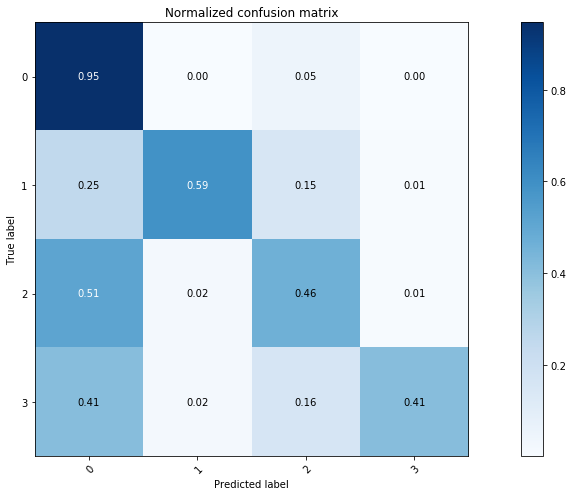

In [273]:
plot_confusion_matrix(y_te, pred_te, np.array([0,1,2,3]),normalize=True, );

In [90]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [81]:
param_names = clf.cv_results_['params'][0].keys()
param_mx = {pname: [str(params[pname]) for params in clf.cv_results_['params']] for pname in param_names}

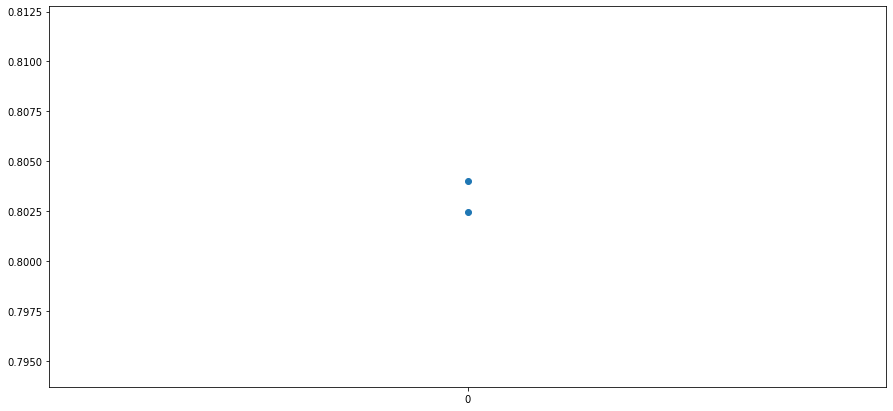

In [57]:
# try to plot effect of different parameters during cv
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 7)

plt.scatter(param_mx['min_impurity_decrease'], means)
plt.show()


Feature ranking:
#1: dhr_std_dev	importance=0.040771	std=0.052873
#2: dhr_var	importance=0.039474	std=0.051480
#3: QZ_iqr	importance=0.030994	std=0.033988
#4: dhr_max	importance=0.030476	std=0.042691
#5: min_interv	importance=0.028964	std=0.035107
#6: dhr_kurtosis	importance=0.026736	std=0.018911	<-- low variance
#7: hr_var	importance=0.026726	std=0.042974
#8: noise_rms	importance=0.026601	std=0.032081
#9: var_interv	importance=0.026567	std=0.038148
#10: std_interv	importance=0.025920	std=0.035713
#11: hr_std_dev	importance=0.024274	std=0.040080
#12: med_numex	importance=0.024187	std=0.029590
#13: dhr_min	importance=0.023374	std=0.035529
#14: dhr_abs_dev	importance=0.018929	std=0.027392
#15: hr_skewness	importance=0.018252	std=0.015133	<-- low variance
#16: med_interv	importance=0.017882	std=0.015615	<-- low variance
#17: QZ_var	importance=0.016989	std=0.019804
#18: hr_median	importance=0.016700	std=0.015235	<-- low variance
#19: hr_mean	importance=0.016402	std=0.014567	<-- low varianc

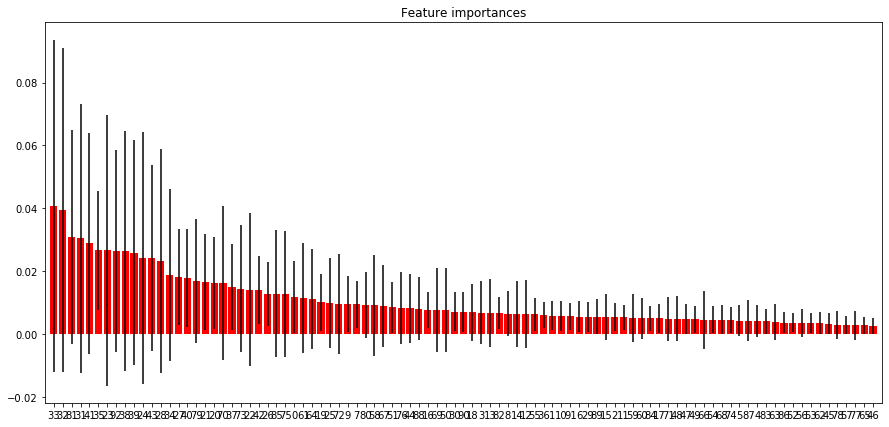

In [58]:
forest = clf.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
nfeats = len(indices)
# Print the feature ranking
print("Feature ranking:")
# myfeats is the list of column names we used
pos = 0
for i in indices:
    pos+=1
    print("#%d: %s\timportance=%f\tstd=%f" % 
          (pos, myfeats[i], importances[i],std[i]), 
          end = '')
    if  importances[i] > std[i]:
        print('\t<-- low variance')
    else: print()

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(nfeats), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(nfeats), indices)
plt.xlim([-1,nfeats])
plt.show()

# Fitting SVC - bad IDEA, waste of time!

In [ ]:
if predicting: raise

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
tuned_parameters = [
                    #{'kernel': ['rbf'], 
                    # 'gamma' : [ 1e-2, 1e-1, 1e-0],
                    # 'C'     : [0.1,0.9,1,1.1,1000],
                    #},
                    {'kernel': ['poly'], 
                     'gamma' : [9e-3, 1e-2, 1.1e-2],
                     'degree': [4],  
                     'C'     : [0.15,0.2,0.3,0.4],
                     'coef0' : [1],
                    },
                   ]

# set probability to true if you want to get confidence estimates later
# (makes fitting slower)
gs_svc = GridSearchCV(SVC(class_weight = weights, probability=False),
                   tuned_parameters, 
                   cv = 5,
                   scoring='f1_micro',
                   n_jobs=-1, verbose=15)


gs_svc.fit(X_tr, y_tr)


print()
print("Grid scores on development set:")
print()
means = gs_svc.cv_results_['mean_test_score']
stds = gs_svc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs_svc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))


In [ ]:
print()

svc_pred_te  = gs_svc.predict(X_te)
print('Plain predictions')
print('test  f1 =', f1_score(y_te, svc_pred_te, average='micro'))
svc_pred_tr = gs_svc.predict(X_tr)
print('train f1 =', f1_score(y_tr, svc_pred_tr, average='micro'))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
samwe = [weights[int(yi)] for yi in y_te]
print(classification_report(y_te, svc_pred_te, sample_weight = samwe))
print()
print("Best parameters set found on development set:")
print()
print(gs_svc.best_params_)

In [ ]:
param_names = gs_svc.cv_results_['params'][0].keys()
param_mx = {pname: 
                [str(params[pname]) for params in gs_svc.cv_results_['params']]
            for pname in param_names}

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 7)

plt.scatter(param_mx['min_impurity_decrease'], means)
plt.show()


In [ ]:
forest = gs_svc.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
nfeats = len(indices)
# Print the feature ranking
print("Feature ranking:")
# myfeats is the list of column names we used
pos = 0
for i in indices:
    pos+=1
    print("#%d: %s\timportance=%f\tstd=%f" % 
          (pos, myfeats[i], importances[i],std[i]), 
          end = '')
    if  importances[i] > std[i]:
        print('\t<-- low variance')
    else: print()

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(nfeats), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(nfeats), indices)
plt.xlim([-1,nfeats])
plt.show()

# Prediction

In [ ]:
if not predicting: raise

In [ ]:
#retrain the model with all the data and best params from cv
{'bootstrap': True, 
 'criterion': 'gini', 
 'max_depth': None, 
 'max_features': 'auto', 
 'max_leaf_nodes': None, 
 'min_impurity_decrease': 0, 
 'min_samples_leaf': 2, 
 'min_samples_split': 2, 
 'min_weight_fraction_leaf': 0, 
 'n_estimators': 3000, 
 'oob_score': False}

rf = RandomForestClassifier(n_estimators = 3000, min_samples_leaf=2, class_weight = weights,
                                          n_jobs=-1
                                         )
rf.fit(X_raw,y_raw)

In [ ]:
rf_tr = rf.predict(X_raw)
print('train f1 =', f1_score(y_raw, rf_tr, average='micro'))

### Careful
This was not quite thought out... If you want to predict for the test set you have to got to the top of the notebook and replace the `train` dataframe with the `test` dataframe, rerun all the pre processing and feature extraction, and make sure NOT to erase the trained model. Just run predict after normalising

In [ ]:
rf_AML = rf.predict(X_raw)

In [ ]:
from datetime import datetime
def prepare_submission(y_graded, comment = ""):
    y_out_template = np.genfromtxt ('sample.csv', delimiter=",")[1:]
    filename = datetime.now().strftime("%m.%d.%H.%M")+"_"+comment+".csv"
    print(filename)
    y_out=y_out_template
    y_out[:,1] = y_graded
    np.savetxt(filename, y_out, delimiter=",",header="id,y",  comments='')

In [ ]:
prepare_submission(rf_AML, 'seb')

# More feature ideas...

In [ ]:
raise # to prevent automatic execution beyond this cell ...

In [ ]:
rows = subsets()[0].sample(3)#.iloc[0]
for id,row in rows.iterrows():
    #print(row.y)
    freqs, power = welch_spectrum(row.avg_tempt, sampling_rate=freq,size=180)
    plt.plot(freqs,power,c='red')
rows = subsets()[1].sample(3)#.iloc[0]
for id,row in rows.iterrows():
    #print(row.y)
    freqs, power = welch_spectrum(row.avg_tempt, sampling_rate=freq,size=180)
    plt.plot(freqs,power,c='blue')
plt.show()


In [ ]:
plt.boxplot([sub['hr_std_dev'] for sub in subsets])
plt.show()

In [ ]:
sample = train.loc[3778]
#sample = train1.sample(1).iloc[0]
ref = train0.loc[537]
#ref = train0.sample(1).iloc[0]

print(sample.id, ": ",sample.y)
print(ref.id, ": ",ref.y, '(ref)')

#plt.plot(sample.ts, sample.X)
plt.plot(sample.ts, sample.filtered, label=str(sample.y))
#plt.plot(templates_ts+sample.rpeaks[1]/freq, sample.templates[1])
#plt.show()

plt.plot(ref.ts, ref.filtered, label=str(ref.y))
#plt.plot(templates_ts+ref.rpeaks[1]/freq, ref.templates[1])

#plt.xlim([9,12])
plt.legend()
plt.show()

plt.plot(sample.heart_rate_ts-1, sample.heart_rate, label=str(sample.y))
plt.plot(   ref.heart_rate_ts*1.3333,    ref.heart_rate, label=str(   ref.y))
plt.plot( sample.heart_rate, label=str(sample.y))
plt.plot( ref.heart_rate, label=str(   ref.y))

plt.legend()
plt.show()



#plt.show()
for template in ref.templates:
    plt.plot(templates_ts, template,c='black')
#plt.plot(templates_ts, ref.avg_tempt, c='black')
for template in sample.templates:
    plt.plot(templates_ts, template)
plt.show()

In [ ]:
ids = [2312, 3606]
plt.boxplot(train.intervs.loc[ids])
plt.xticks(range(1+len(ids)), train.id.loc[ids])
plt.show()
plt.boxplot(train.heart_rate.loc[ids])
plt.show()

In [ ]:
train.loc[2312].var_interv

In [ ]:
train.loc[3606].var_interv

In [ ]:
subset = train
for id, sample in subset.sample(10).iterrows():
    print(id,':',sample.y)
    plt.plot(sample.intervs, label='filt')
    plt.ylim([50,500])
    #plt.plot(sample.ecg['ts'], sample.X, label='raw')
    #plt.plot(sample['templates_ts'], sample['templates'], label='template')
    plt.legend()
    plt.show()
    #plt.boxplot([sub['var_interv'] for sub in subsets])
plt.show()

In [ ]:
plt.boxplot([np.var(hrts) for sub in subsets for hrts in sub.heart_rate_ts])
plt.show()

In [ ]:
for subset in [train0, train1, train2, train3]:
    sample = subset.sample(1).iloc[0]
    print("id:",sample.id, '\tclass:', sample.y)
    plt.hist(sample.intervs,20, label=str(sample.y))
plt.legend()
plt.show()

In [ ]:
i=0
for subset in [train0, train1]:#, train2, train3]:
    plt.scatter(subset.y, subset.var_interv, label=i, s=1)
    plt.ylim([0,50000])
    i+=1
    plt.legend()
plt.show()

In [ ]:
[sample.var_interv for _, sample in train.loc[ids].iterrows()]

In [ ]:
ids =  []
for subset in [train0, train1, train2, train3]:
    for k in subset.sample(1).index.values:
        ids.append(k)
        sample = subset.loc[k]
        print("id:",k, 'class:', sample.y,'length:', len(sample.rpeaks))
        #for template in sample.ecg['templates'][5:-5]:
        #    plt.plot(template)
        #plt.show()
        plt.plot(sample.avg_tempt)
        plt.plot(sample.max_tempt)
        plt.plot(sample.min_tempt)
        plt.show()

#plt.legend()
#plt.show()

plt.boxplot(train.intervs[ids])
plt.show()

# CODE DUMPSTER:

In [ ]:
dhr = [np.diff(hr) for hr in train.heart_rate_ts]
plt.plot(dhr[0])

In [ ]:
#row = randrow(0)
#print(row.id,'y:',row.y)
#print('ntemps', row.n_tempts)
gfs=[get_g_feats(randrow(i).templates) for i in range(4)]
for feat in gfs[0]:
    print(feat)
    plt.boxplot([gf[feat] for gf in gfs])
    plt.show()

In [ ]:
row = randrow(-1)
#signal = row.avg_tempt[:3000]
signal = row.avg_tempt[:3000]
print(row.id,'y:',row.y)
extrema, values = find_extrema(signal)
plt.plot(extrema, values)
plt.plot(signal)
#R_peaks, S_point, Q_point = EKG_QRS_detect(signal, freq, True, True)
#print(S_point-Q_point)
R = np.array([60]) # R is always at sample 60 within the template
S = find_S_point(signal, R)[0]
Q = find_Q_point(signal, R)[0]
R=R[0]
S_val = signal[S]
R_val = signal[R]
Q_val = signal[Q]
plt.scatter([Q,R,S],[Q_val,R_val,S_val])
print(S-Q)
print(len(extrema))
zeros = zero_cross(signal)['zeros']
QZ = np.max(zeros[zeros<Q])
SZ = np.min(zeros[zeros>S])
plt.axvline(x=QZ)
plt.axvline(x=SZ)